# Render a textured mesh at specified pose to obtain a image using PyTorch3D
This is a demo shows how to:
- load a mesh and textures from an `.obj` file.
- set up a renderer
- load structure-from-motion data
- render a mesh

# 0. Install and Import modules
Install [PyTorch3D](https://github.com/facebookresearch/pytorch3d) and import modules we need.

In [1]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    PerspectiveCameras,
    AmbientLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
)

# Add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


# 1. Load a mesh and texture file
Load an `.obj` file and its associated `.mtl` file and create a Textures and Meshes object. We use [**spot**](http://www.cs.cmu.edu/~kmcrane/Projects/ModelRepository/index.html#spot) as an example.

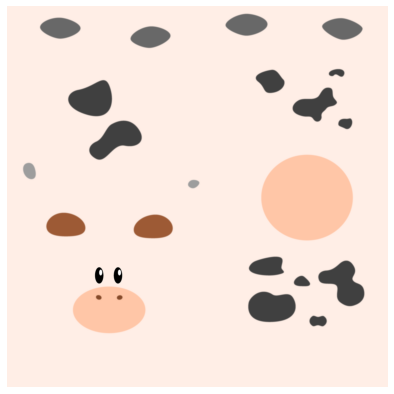

In [18]:
# Set paths
DATA_DIR = "./data_sample"
obj_filename = os.path.join(DATA_DIR, "spot/spot.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# Visualize the texture map
plt.figure(figsize=(7,7))
texture_image=mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

# 2. Load SFM data
The following module shows how to load structure-from-motion (SFM) data provided by us. The original spot dataset does not include pose information so we load poses from other scene to just illustrate this method. 

In [19]:
import json
import math
import imageio.v2 as imageio
import numpy as np


def qvec2rotmat(qvec):
    return np.array([
        [
                    1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
                    2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
                    2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]
                    ], [
            2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
            1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
            2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]
        ], [
            2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
            2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
            1 - 2 * qvec[1]**2 - 2 * qvec[2]**2
        ]
    ])


def load_sfm_data(basedir, testskip=1):
    with open(os.path.join(basedir, "colmap/cameras.txt"), "r") as f:
        angle_x = math.pi / 2
        for line in f:
            # 1 SIMPLE_RADIAL 2048 1536 1580.46 1024 768 0.0045691
            # 1 OPENCV 3840 2160 3178.27 3182.09 1920 1080 0.159668 -0.231286 -0.00123982 0.00272224
            # 1 RADIAL 1920 1080 1665.1 960 540 0.0672856 -0.0761443
            if line[0] == "#":
                continue
            els = line.split(" ")
            w = float(els[2])
            h = float(els[3])
            image_size = (int(h), int(w))
            fl_x = float(els[4])
            fl_y = float(els[4])
            k1 = 0
            k2 = 0
            p1 = 0
            p2 = 0
            cx = w / 2
            cy = h / 2
            if els[1] == "SIMPLE_PINHOLE":
                cx = float(els[5])
                cy = float(els[6])
            elif els[1] == "PINHOLE":
                fl_y = float(els[5])
                cx = float(els[6])
                cy = float(els[7])
            elif els[1] == "SIMPLE_RADIAL":
                cx = float(els[5])
                cy = float(els[6])
                k1 = float(els[7])
            elif els[1] == "RADIAL":
                cx = float(els[5])
                cy = float(els[6])
                k1 = float(els[7])
                k2 = float(els[8])
            elif els[1] == "OPENCV":
                fl_y = float(els[5])
                cx = float(els[6])
                cy = float(els[7])
                k1 = float(els[8])
                k2 = float(els[9])
                p1 = float(els[10])
                p2 = float(els[11])
            else:
                print("unknown camera model ", els[1])
            angle_x = math.atan(w / (fl_x * 2)) * 2
            angle_y = math.atan(h / (fl_y * 2)) * 2
            fovx = angle_x * 180 / math.pi
            fovy = angle_y * 180 / math.pi

    with open(os.path.join(basedir, "colmap/images.txt"), "r") as f:
        i = 0
        metas = []
        bottom = np.array([0.0, 0.0, 0.0, 1.0]).reshape([1, 4])
        up = np.zeros(3)
        image_folder = os.path.join(basedir, "images/")
        for line in f:
            line = line.strip()
            if line[0] == "#":
                continue
            i = i + 1
            if i % 2 == 1:
                # 1-4 is quat, 5-7 is trans, 9ff is filename (9, if filename contains no spaces)
                elems = line.split(" ")
                name = '_'.join(elems[9:])
                image_id = int(elems[0])
                qvec = np.array(tuple(map(float, elems[1:5])))
                tvec = np.array(tuple(map(float, elems[5:8])))
                R = qvec2rotmat(-qvec)
                t = tvec.reshape([3, 1])
                m = np.concatenate([np.concatenate([R, t], 1), bottom], 0)
                meta = {'pose': m, 'name': name}
                metas.append(meta)

    return metas, fl_x, fl_y, cx, cy, image_size


# 3. Coordinate transformation
PyTorch3D uses left-up-front (+X left, +Y up, +Z in) system while colmap adopts right-down-front (+X right, +Y down, +Z in, just like OpenCV) format. Therefore, we need to convert local camera coordinate system.

In [20]:
scene_dir = './data_sample/spot/'
metas, fx, fy, cx, cy, image_size = load_sfm_data(scene_dir, testskip=1)

torch3d_T_colmap = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])

for meta in metas:
    pose = meta['pose']
    R = pose[0:3, 0:3]
    T = pose[0:3, -1]
    R = (torch3d_T_colmap @ R).T
    T = (torch3d_T_colmap @ T)
    R = torch.from_numpy(R).unsqueeze(0)
    T = torch.from_numpy(T).unsqueeze(0)


# 4. Create a renderer


In [ ]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction.
cameras = PerspectiveCameras(device=device, R=R, T=T, focal_length=(
    (fx, fy),), principal_point=((cx, cy),), in_ndc=False, image_size=(image_size,))
print(image_size)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# (h,w). As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for
# explanations of these parameters. 
raster_settings = RasterizationSettings(
    image_size=image_size,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Place a ambient light to the object.
lights = AmbientLights(device=device, ambient_color=None)

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will
# interpolate the texture uv coordinates for each vertex, sample from a texture image and
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)


# 5. Render the mesh
Render the `spot.obj` with given pose.

In [ ]:
# render
images = renderer(mesh)

# display
plt.figure(figsize=(10.08, 7.56), dpi=100, frameon=False)
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
